In [16]:
#Modelos que serão testados para o projeto
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

#Preprocessamento dos dados categoricos
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

#Valiação dos parametros do modelo escolhido
from sklearn.model_selection import RandomizedSearchCV

#Serve para das os splits dos dados na validação
from sklearn.model_selection import KFold

#Separa a base de dados em treino e testes
from sklearn.model_selection import train_test_split

#Metricas para a avaliação do modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Escalonar os dados
from sklearn.preprocessing import RobustScaler

#Manipulação dos dados
import pandas as pd
import numpy as np

#Visualização  de dados
import seaborn as sns
import matplotlib.pyplot as plt 

#Ter acesso aos metodos de graficos
import sys
import scipy.stats as stats
%load_ext autoreload
%autoreload 2
sys.path.append('../Utils')
from avaliacaoModelo import AvaliacaoMD



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
avalicao = AvaliacaoMD()

In [18]:
df = pd.read_csv("../Dados/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520




Primeiro, vou tratar os dados categóricos, transformando a coluna **region** em variáveis numéricas usando o **OneHotEncoder**. Para as colunas **sex** e **smoker**, aplicarei a função `apply` para converter seus valores em números. Depois dessa preparação, para os modelos lineares, realizarei a **escalagem** dos dados para melhorar o desempenho e a convergência dos algoritmos.



In [19]:
# Separar X e y
X = df.drop(["charges"], axis=1)
y = np.log1p(df["charges"])

# Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar o encoder e dar fit no treino
encoder = OneHotEncoder(sparse_output=False)  # no scikit-learn 1.2+ usa sparse_output; se der erro, volta para sparse=False
region_encoded_train = encoder.fit_transform(X_train[['region']])

# Pegar nomes das colunas
nomes_colunas = encoder.get_feature_names_out(['region'])

# Criar DataFrame das dummies para treino
X_train_En = pd.DataFrame(region_encoded_train, columns=nomes_colunas, index=X_train.index)

# Concatenar com o X_train (e remover a coluna original, se quiser)
X_train = pd.concat([X_train.drop('region', axis=1), X_train_En], axis=1)

# Agora transformar o X_test usando o encoder já treinado (sem fit_transform, só transform)
region_encoded_test = encoder.transform(X_test[['region']])

# Criar DataFrame das dummies para teste (mesmas colunas, índices originais)
X_test_En = pd.DataFrame(region_encoded_test, columns=nomes_colunas, index=X_test.index)

# Concatenar com o X_test (removendo a coluna original)
X_test = pd.concat([X_test.drop('region', axis=1), X_test_En], axis=1)

In [20]:
#Tratando os dados de fumantes e de gênero

#Se for fumante recebe 1 se não 0
X_train["smoker"] = X_train["smoker"].apply(lambda x: 1 if x =="yes" else 0)
X_test["smoker"] = X_test["smoker"].apply(lambda x: 1 if x =="yes" else 0)

#Se for masculino recebe 1 se não 0
X_train["sex"] = X_train["sex"].apply(lambda x: 1 if x =="male" else 0)
X_test["sex"] = X_test["sex"].apply(lambda x: 1 if x =="male" else 0)

In [21]:
X_train

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
560,46,0,19.950,2,0,0.0,1.0,0.0,0.0
1285,47,0,24.320,0,0,1.0,0.0,0.0,0.0
1142,52,0,24.860,0,0,0.0,0.0,1.0,0.0
969,39,0,34.320,5,0,0.0,0.0,1.0,0.0
486,54,0,21.470,3,0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1095,18,0,31.350,4,0,1.0,0.0,0.0,0.0
1130,39,0,23.870,5,0,0.0,0.0,1.0,0.0
1294,58,1,25.175,0,0,1.0,0.0,0.0,0.0
860,37,0,47.600,2,1,0.0,0.0,0.0,1.0


Agora vou preparar os dados para os modelos lineares

In [22]:
colunas = X_train.columns
scaler = RobustScaler()

dados_escalonado_treino = scaler.fit_transform(X_train)
dados_escalonado_teste = scaler.transform(X_test)

X_train_escalado = pd.DataFrame(dados_escalonado_treino, columns=colunas)
X_test_escalado = pd.DataFrame(dados_escalonado_teste, columns=colunas)
X_train_escalado

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,0.270833,-1.0,-1.237449,0.5,0.0,0.0,1.0,0.0,0.0
1,0.312500,-1.0,-0.710387,-0.5,0.0,1.0,0.0,0.0,0.0
2,0.520833,-1.0,-0.645259,-0.5,0.0,0.0,0.0,1.0,0.0
3,-0.020833,-1.0,0.495703,2.0,0.0,0.0,0.0,1.0,0.0
4,0.604167,-1.0,-1.054123,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1065,-0.895833,-1.0,0.137494,1.5,0.0,1.0,0.0,0.0,0.0
1066,-0.020833,-1.0,-0.764662,2.0,0.0,0.0,0.0,1.0,0.0
1067,0.770833,0.0,-0.607267,-0.5,0.0,1.0,0.0,0.0,0.0
1068,-0.104167,-1.0,2.097392,0.5,1.0,0.0,0.0,0.0,1.0


Feito a separação dos dados, vamos partir para a avaliação dos modelos e qual irá se sair melhor.

In [23]:
def avaliaModelo(y_true, y_pred):
    metrics = {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R²': r2_score(y_true, y_pred),
        'Adjusted R²': 1 - (1-r2_score(y_true, y_pred))*(len(y_true)-1)/(len(y_true)-X.shape[1]-1)
    }
    return metrics

def testaModeloRegreção(X, y, modelo):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    modelo = modelo()
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    metricas = avaliaModelo(y_test, y_pred)
    print(modelo)
    for name, value in metricas.items():
        print(f"{name}: {value:.4f}")

In [24]:

testaModeloRegreção(X_train, y_train, Lasso)
testaModeloRegreção(X_train_escalado, y_train, LinearRegression)
testaModeloRegreção(X_train, y_train, Ridge)
testaModeloRegreção(X_train, y_train,RandomForestRegressor)
testaModeloRegreção(X_train, y_train,XGBRegressor)

Lasso()
MSE: 0.6252
RMSE: 0.7907
MAE: 0.6436
R²: 0.2664
Adjusted R²: 0.2452
LinearRegression()
MSE: 0.2456
RMSE: 0.4956
MAE: 0.2976
R²: 0.7118
Adjusted R²: 0.7035
Ridge()
MSE: 0.2453
RMSE: 0.4953
MAE: 0.2977
R²: 0.7122
Adjusted R²: 0.7039
RandomForestRegressor()
MSE: 0.2124
RMSE: 0.4609
MAE: 0.2286
R²: 0.7507
Adjusted R²: 0.7435
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy

Após a análise dos reultados, nota-se que o RandomFerestRegressor se saiu melhor, então vou continuar com ele até o final. Vamos passar para o teste dos hiper parametros! Irei utilizar o RandomizedSeachCV pois o custo computacional com é melhor!

In [25]:

# Espaço de parâmetros para busca
param_dist = {
    'n_estimators': np.arange(100, 500, 50),
    'max_depth': [None] + list(np.arange(5, 30, 5)),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 5),
    'max_features': ['sqrt', 'log2', 0.8, None],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# RandomSearch com validação cruzada
rf_random = RandomizedSearchCV(
    estimator=rf, #O modelo que irá ser usado
    param_distributions=param_dist, #os parametros que serão testados
    n_iter=50, #Numeros de combinações que vão ser testadas 
    cv=kf, #Como os dados serão divididos
    scoring='neg_mean_absolute_error', #a metrtica que será avaliada
    verbose=2, #Detakhes
    random_state=42,
    n_jobs=-1 #Controla o paralelismo da execução
)

rf_random.fit(X_train, y_train)

# Melhores parâmetros
print("Melhores parâmetros:", rf_random.best_params_)
print("Melhor MAE:", -rf_random.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Melhores parâmetros: {'n_estimators': 400, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 0.8, 'max_depth': 10, 'bootstrap': True}
Melhor MAE: 0.2019483728975017


Com a analise do MAE(Erro Médio Absoluto) percebe-se que houve uma redução significativa entre a baseline(23.84) para 20.41, o que mostra uma redução nos erros no modelo. Agora para finalizar, vou analisar a eficiência do meu modelo com dados que ele nunca viu, isso vai coclocar ele aprova e vermos se vai se sair bem!

In [51]:
# Modelo com melhores parâmetros
melhorModelo = rf_random.best_estimator_

# Avaliação no teste
y_pred = melhorModelo.predict(X_test)


# Avaliação
resultados = avaliaModelo(y_test, y_pred)
maeTest = resultados['MAE']
rsmeTest = resultados['RMSE']
r2Test = resultados['R²']

# Mostrar as métricas
for k, v in resultados.items():
    print(f"{k}: {v:.4f}")
    
# Comparação com baseline
print("COMPARAÇÃO COM O MODELO SEM HIPER PARÂMETROS")
print(f"MAE: Melhoria sobre o modelo padrão: {(0.2286 - maeTest)/0.2286*100:.1f}%")
print(f"R2: Melhoria sobre o modelo padrão: {(r2Test - 0.7332)/0.7332*100:.1f}%")
print(f"RSME: Melhoria sobre o modelo padrão: {(0.4745 - rsmeTest)/0.4745*100:.1f}%")

MSE: 0.1245
RMSE: 0.3529
MAE: 0.1804
R²: 0.8614
Adjusted R²: 0.8583
COMPARAÇÃO COM O MODELO SEM HIPER PARÂMETROS
MAE: Melhoria sobre o modelo padrão: 21.1%
R2: Melhoria sobre o modelo padrão: 17.5%
RSME: Melhoria sobre o modelo padrão: 25.6%


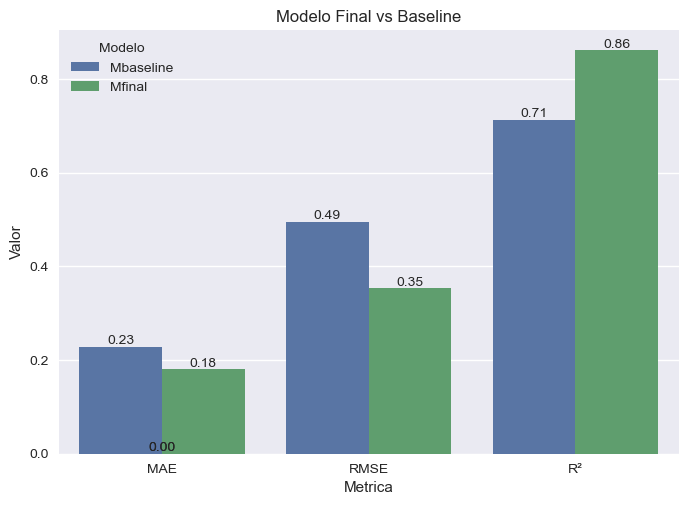

In [52]:
# Criar DataFrame com os dados

df_valores = pd.DataFrame({
    'Valores': [0.2284, 0.4945, 0.7132, 0.1801, 0.3529, 0.8614],
    'Metrica': ['MAE', 'RMSE', 'R²', 'MAE', 'RMSE', 'R²'],
    'Modelo' : ['Mbaseline', 'Mbaseline', 'Mbaseline', 'Mfinal', 'Mfinal', 'Mfinal']
},)

avalicao.diferencaModeloFinalBL(df_valores)



O modelo ajustado com hiperparâmetros obteve resultados bastante expressivos no conjunto de dados de teste. Abaixo estão as principais métricas alcançadas, com suas interpretações:

1. **MSE (Mean Squared Error)**: O modelo apresentou um MSE de 0,1245, indicando o erro quadrático médio das previsões em relação aos valores reais.

2. **RMSE (Root Mean Squared Error)**: Com um RMSE de 0,3529 (35,29%), o modelo teve um erro médio quadrático raiz relativamente baixo, reforçando sua capacidade de fazer previsões precisas e minimizar a influência de grandes erros pontuais.

3. **MAE (Mean Absolute Error)**: O modelo apresentou um MAE de 0,1804 (18,04%), indicando que, em média, as previsões do modelo estão erradas em cerca de 18,04% em relação ao valor real. Essa métrica é útil para avaliar erros absolutos médios sem dar peso desproporcional a grandes desvios.

4. **R² (Coeficiente de Determinação)**: O modelo obteve um R² de 0,8614 (86,14%), indicando que ele consegue explicar 86,14% da variância dos dados no conjunto de teste. Esse é um resultado muito positivo, mostrando que o modelo captura bem as relações entre as variáveis preditoras e a variável-alvo.

5. **Adjusted R² (R² Ajustado)**: O valor ajustado foi de 0,8583 (85,83%), confirmando a boa capacidade explicativa do modelo mesmo considerando o número de variáveis utilizadas.

---

### Comparação com o modelo padrão (sem ajuste de hiperparâmetros):

| Métrica | Melhoria sobre o modelo padrão |
| ------- | ------------------------------ |
| MAE     | 21,1%                          |
| R²      | 17,5%                          |
| RMSE    | 25,6%                          |

---

Por fim, as variáveis mais influentes no modelo ajustado serão analisadas para identificar quais características mais impactam as previsões e auxiliar na interpretação dos resultados para decisões práticas.


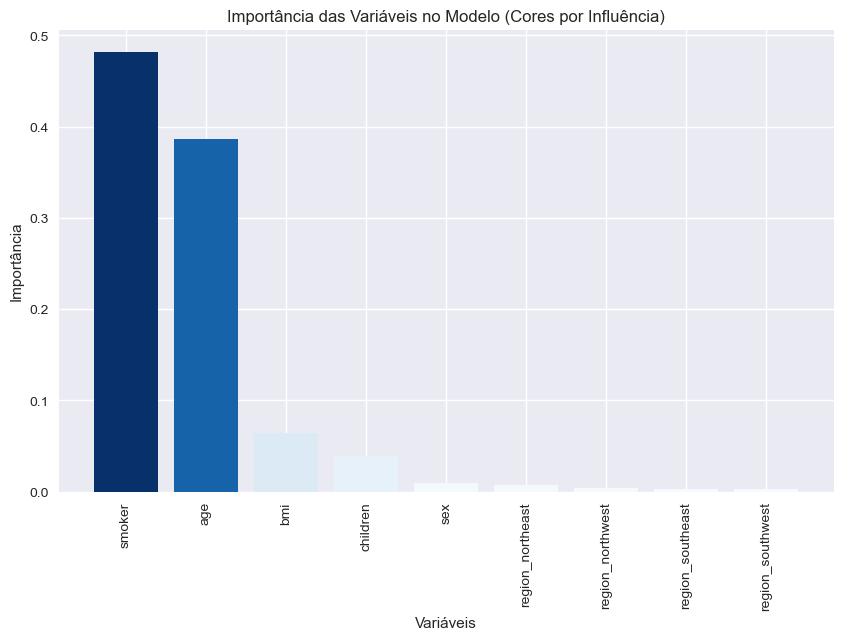

In [53]:
avalicao.importanciaVariaveis(X_train, melhorModelo)

Com base na análise apresentada no gráfico, observa-se que as variáveis **"smoker_yes"** (indicando se o paciente é fumante) e **"age"** (idade) possuem maior influência nos custos dos seguros médicos. Essas duas variáveis se destacam significativamente em relação às demais, como **"bmi"** (índice de massa corporal) e **"children"** (número de filhos), que apresentam influência muito menor.

Dessa forma, o modelo desenvolvido para prever os gastos médicos dos pacientes identifica **o tabagismo e a idade como os principais fatores determinantes** para os custos. Essas variáveis devem, portanto, ser priorizadas nas análises e recomendações relacionadas à precificação ou políticas de prevenção em saúde.

## Análise com Dados Originais (Validação Complementar)

Para garantir a robustez dos resultados e permitir uma interpretação direta em valores monetários, complementamos nossa análise testando o modelo nos dados originais (sem transformação logarítmica). Esta abordagem visa:

✓ **Traduzir métricas** para valores absolutos (R$) com significado prático imediato  
✓ **Validar a consistência** das relações identificadas (tabagismo e idade como drivers principais)  
✓ **Comparar desempenho** entre abordagens transformadas e não transformadas  

### Metodologia

- **Modelo utilizado**: RandomForestRegressor com os mesmos hiperparâmetros otimizados  
- **Métricas calculadas**:
  - `MAE` (Erro Absoluto Médio em R$)  
  - `RMSE` (Raiz do Erro Quadrático Médio em R$)  
  - `R²` (Coeficiente de Determinação)  



In [55]:

avalicao.avaliacaoDeEscalaOriginal(y_test, y_pred)


        AVALIAÇÃO DO MODELO NA ESCALA ORIGINAL (R$)         
• MAE (Erro Absoluto Médio):       R$ 1.950,38 (16,00%)
• RMSE (Raiz do Erro Quadrático):  R$ 4.312,96 (33,26%)
• R² (Poder Explicativo):          88.02%
• Custo Médio de Referência:       R$ 12.968,32




### **Análise de Trade-offs no Modelo de Custos Médicos**

#### **📌 Contexto do Projeto**

Desenvolvi um modelo de previsão de custos médicos usando **RandomForestRegressor** com uma base de **1.339 registros**. A variável target (`charges`) apresentava **assimetria acentuada**, então apliquei uma **transformação logarítmica** para melhorar a performance do modelo.

Mesmo após ajustes, o **RMSE ficou em 33,26% do custo médio**, indicando que valores extremos (outliers) ainda impactam significativamente as previsões.

---

### **🔍 Trade-off Enfrentado**

**"Remover outliers para melhorar as métricas ou mantê-los para preservar casos clinicamente relevantes?"**

| **Opção**            | **Vantagens**                            | **Desvantagens**                                                               |
| -------------------- | ---------------------------------------- | ------------------------------------------------------------------------------ |
| **Remover outliers** | - Melhora MAE/RMSE artificialmente       | - Perde casos raros, porém importantes (ex: pacientes com custos excepcionais) |
| **Manter outliers**  | - Preserva a integridade dos dados reais | - Métricas menos otimizadas (RMSE mais alto)                                   |

#### **Minha Decisão**

Optei por **manter os outliers**, pois:
✅ **Reflete a realidade dos dados**: Custos médicos têm variações extremas (ex: cirurgias complexas vs. consultas simples).
✅ **Evita viés em casos críticos**: Pacientes com custos altos são justamente os que mais precisam de previsão acurada.
✅ **Transparência**: Melhor comunicar um RMSE alto, mas realista, do que métricas "infladas" por filtros excessivos.

---

### **📊 Resultados e Interpretação**

| **Métrica**                   | **Valor**             | **Significado**                                                                         |
| ----------------------------- | --------------------- | --------------------------------------------------------------------------------------- |
| **MAE**                       | R\$ 1.950,38 (16,00%) | Erro médio "aceitável" para o domínio de saúde, considerando a variabilidade dos dados. |
| **RMSE**                      | R\$ 4.312,96 (33,26%) | Indica a presença de outliers, mas **não invalida** o modelo.                           |
| **R²**                        | **88,02%**            | Excelente poder explicativo, mesmo com a variação natural dos dados.                    |
| **Custo Médio de Referência** | R\$ 12.968,32         | Valor médio geral dos custos na base, para contextualizar os erros.                     |

